In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from scipy.stats import multivariate_normal

In [8]:
# Function to create a grid for plotting
def make_grid(box_cord, ngrid=100):
    x_min, x_max, y_min, y_max = box_cord
    x_range = np.linspace(x_min - 1, x_max + 1, ngrid)
    y_range = np.linspace(y_min - 1, y_max + 1, ngrid)
    xx, yy = np.meshgrid(x_range, y_range)
    return xx, yy

# Function to plot contours for a multivariate normal distribution
def plot_contours(mean, cov, box_cord=[-3, 3, -3, 3], c="b"):
    xx, yy = make_grid(box_cord)
    xy = np.c_[xx.ravel(), yy.ravel()]
    prob = multivariate_normal.pdf(xy, mean=mean, cov=cov)
    prob = prob.reshape(xx.shape)
    plt.contour(xx, yy, prob, colors=c)

# Function to generate synthetic data for classification
def generate_data():
    np.random.seed(0)
    X, y = make_classification(
        n_samples=500,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_clusters_per_class=1,
    )
    return X, y

# Function to plot decision boundaries for a given classifier
def plot_decision_boundaries(clf, box_cord=[-5, 5, -5, 5]):
    xx, yy= make_grid(box_cord)
    points = np.c_[xx.ravel(), yy.ravel()]

    # plot decision boundary
    y_score = clf.predict(points)
    y_score = y_score.reshape(xx.shape)
    plt.contourf(
        xx,
        yy,
        y_score,
        levels=[y_score.min(), 0, y_score.max()],
        alpha=0.3,
        cmap=plt.cm.coolwarm,
    )

    plt.contour(xx, yy, y_score, [0], linewidths=2, colors="k")

In [9]:
class LDA:
    def __init__(self, num_features=2) -> None:
        self.num_features = num_features # Number of features
        self.w = np.ones((num_features)) # Weight vector
        self.w0 = 0 # Bias term
        self.pi = 0.5   # Prior probability of class 0
        self.mean_class0 = np.zeros((num_features)) # Mean of class 0
        self.mean_class1 = np.ones((num_features))  # Mean of class 1
        self.cov_class0 = np.eye(num_features) # Covariance matrix of class 0
        self.cov_class1 = np.eye(num_features)  # Covariance matrix of class 1
        self.cov = self.pi * self.cov_class0 + (1-self.pi) * self.cov_class1 # Pooled covariance matrix

    def fit(self, X, y) -> None:
        assert (
            min(y) == 0 and max(y) == 1
        ), "This implementation is only for binary classification"

        # Number of samples in each class
        n_class0 = sum(y == 0)
        n_class1 = sum(y == 1)
        n_total = len(y)

        # Class priors
        self.pi = n_class1 / n_total

        # Compute the means for each class
        self.mean_class0 = X[y == 0].mean(axis=0)
        self.mean_class1 = X[y == 1].mean(axis=0)

        # Compute the covariance matrices for each class
        self.cov_class0 = np.cov(X[y == 0], rowvar=False)
        self.cov_class1 = np.cov(X[y == 1], rowvar=False)

        # Pooled covariance matrix
        self.cov = self.pi * self.cov_class1 + (1 - self.pi) * self.cov_class0

        # LDA weights (linear decision boundary)
        self.w = np.linalg.inv(self.cov).dot(self.mean_class1 - self.mean_class0)

        # Intercept term
        self.w0 = (
            -0.5 * (self.mean_class1.T @ np.linalg.inv(self.cov) @ self.mean_class1)
            + 0.5 * (self.mean_class0.T @ np.linalg.inv(self.cov) @ self.mean_class0)
            + np.log(self.pi / (1 - self.pi))
        )
        self.cov = self.pi * self.cov_class0 + (1-self.pi) * self.cov_class1

    def predict(self, X) -> np.ndarray:
        yhat = X.dot(self.w) + self.w0
        return yhat

    def calc_accuracy(self, X, y) -> float:
        # Calculate the linear discriminant scores
        scores = X @ self.w + self.w0

        # Predict the labels (threshold at 0 for binary classification)
        y_pred = (scores > 0).astype(int)

        # Calculate the number of correct predictions
        correct_predictions = np.sum(y_pred == y)

        # Compute accuracy
        accuracy = correct_predictions / len(y)

        return accuracy
        #return 0.5

    def plot_params(self):
        # Plot the mean of class 0
        plt.scatter(
            self.mean_class0[0],
            self.mean_class0[1],
            s=100,
            c="yellow",
            edgecolors="k",
            marker="X",
        )
        # Plot the mean of class 1
        plt.scatter(
            self.mean_class1[0],
            self.mean_class1[1],
            s=100,
            c="yellow",
            edgecolors="k",
            marker="X",
        )

        # Plot the contours
        plot_contours(self.mean_class0, self.cov, c="b")
        plot_contours(self.mean_class1, self.cov, c="r")


In [10]:
class QDA:
    def __init__(self, num_features=2) -> None:
        self.num_features = num_features
        self.pi = 0.5
        self.mean_class0 = np.zeros((num_features))
        self.mean_class1 = np.ones((num_features))
        self.cov_class0 = np.eye(num_features)
        self.cov_class1 = np.eye(num_features)

    def fit(self, X, y) -> None:
        assert (
            min(y) == 0 and max(y) == 1
        ), "This implementation is only for binary classification"

        # Calculate the number of samples in each class
        n_class0 = np.sum(y == 0)
        n_class1 = np.sum(y == 1)
        n_total = len(y)

        # Class priors
        self.pi = n_class1 / n_total

        # Mean vectors
        self.mean_class0 = X[y == 0].mean(axis=0)
        self.mean_class1 = X[y == 1].mean(axis=0)

        # Covariance matrices
        self.cov_class0 = np.cov(X[y == 0], rowvar=False)
        self.cov_class1 = np.cov(X[y == 1], rowvar=False)

    # QDA: Calculate the quadratic discriminant function
    def qda_discriminant(x, mean, inv_cov, det_cov, pi):
        diff = x - mean
        w0 = 0.5 * np.einsum("mi,ij,mj->m", diff, inv_cov, diff)
        return -0.5 * np.log(det_cov) - w0 + np.log(pi)

    def predict(self, X) -> np.ndarray:
        inv_cov_class0 = np.linalg.inv(self.cov_class0)
        inv_cov_class1 = np.linalg.inv(self.cov_class1)
        det_cov_class0 = np.linalg.det(self.cov_class0)
        det_cov_class1 = np.linalg.det(self.cov_class1)
        # QDA decision boundary
        yhat = QDA.qda_discriminant(
            X,
            self.mean_class0,
            inv_cov_class0,
            det_cov_class0,
            self.pi,
        ) - QDA.qda_discriminant(
            X,
            self.mean_class1,
            inv_cov_class1,
            det_cov_class1,
            1 - self.pi,
        )
        return yhat

    def calc_accuracy(self, X, y) -> float:
        scores = self.predict(X)
        y_pred = (scores > 0).astype(int)  # Threshold at 0 for binary classification

        accuracy = np.sum(y_pred == y) / len(y)

        return accuracy
        # return 0.5

    def plot_params(self):
        # Plot the mean of class 0
        plt.scatter(
            self.mean_class0[0],
            self.mean_class0[1],
            s=100,
            c="yellow",
            edgecolors="k",
            marker="X",
        )
        plt.scatter(
            self.mean_class1[0],
            self.mean_class1[1],
            s=100,
            c="yellow",
            edgecolors="k",
            marker="X",
        )

        # Plot the contours
        plot_contours(self.mean_class0, self.cov_class0, c="b")
        plot_contours(self.mean_class1, self.cov_class1, c="r")

In [11]:
# Generate synthetic data
X, y = generate_data()

# Initialize the LDA classifiers
lda = LDA()
lda.fit(X, y)
lda_acc = lda.calc_accuracy(X, y)
print(f"LDA accuracy: {lda_acc}")

# Initialize the QDA classifiers
qda = QDA()
qda.fit(X, y)
qda_acc = qda.calc_accuracy(X, y)
print(f"QDA accuracy: {qda_acc}")

LDA accuracy: 0.866
QDA accuracy: 0.076


(-5.0, 5.0)

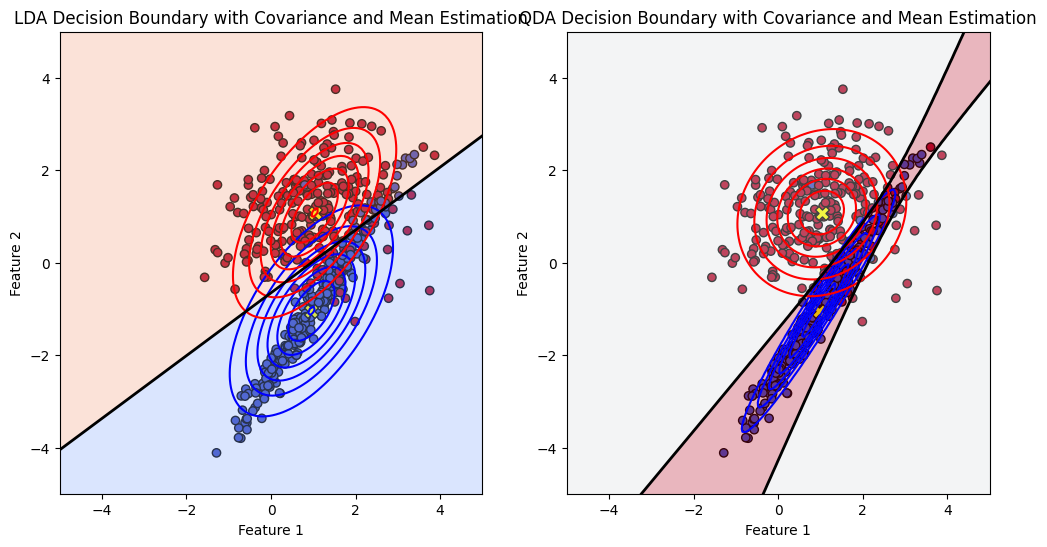

In [12]:
plt.figure(figsize=(12, 6))

# Plot LDA
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.coolwarm)
lda.plot_params()
plot_decision_boundaries(lda)
plt.title("LDA Decision Boundary with Covariance and Mean Estimation")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# Plot QDA
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.coolwarm)
qda.plot_params()
plot_decision_boundaries(qda)

plt.title("QDA Decision Boundary with Covariance and Mean Estimation")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim(-5, 5)
plt.ylim(-5, 5)